### **1. Imports**

In [2]:
!pip install dython

In [3]:
# Importing all the libraries used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_dark"
from dython.nominal import associations
from scipy.stats import mode
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, hamming_loss, jaccard_score, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import joblib
import folium
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [5]:
!wget -O transactions.csv https://www.dubaipulse.gov.ae/dataset/3b25a6f5-9077-49d7-8a1e-bc6d5dea88fd/resource/a37511b0-ea36-485d-bccd-2d6cb24507e7/download/transactions.csv

--2024-08-04 11:30:58--  https://www.dubaipulse.gov.ae/dataset/3b25a6f5-9077-49d7-8a1e-bc6d5dea88fd/resource/a37511b0-ea36-485d-bccd-2d6cb24507e7/download/transactions.csv
Resolving www.dubaipulse.gov.ae (www.dubaipulse.gov.ae)... 91.73.143.12
Connecting to www.dubaipulse.gov.ae (www.dubaipulse.gov.ae)|91.73.143.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773623392 (738M) [text/csv]
Saving to: ‘transactions.csv’

transactions.csv    100%[===================>] 737.78M   518KB/s    in 24m 30s 

2024-08-04 11:55:31 (514 KB/s) - ‘transactions.csv’ saved [773623392/773623392]



In [7]:
#dataset found on:
#https://www.dubaipulse.gov.ae/data/dld-transactions/dld_transactions-open

# Reading the data from the csv file
transactions_df = pd.read_csv('transactions.csv')
transactions_df.head()

,transaction_id,procedure_id,trans_group_id,trans_group_ar,trans_group_en,procedure_name_ar,procedure_name_en,instance_date,property_type_id,property_type_ar,...,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,1-11-2022-27285,11,1,مبايعات,Sales,بيع,Sell,09-11-2022,1,أرض,...,NaN,0,929.03,4100000.0,4413.21,NaN,NaN,7.0,1.0,0.0
1,1-11-2003-1010,11,1,مبايعات,Sales,بيع,Sell,08-07-2003,4,فيلا,...,NaN,0,896.61,2500000.0,2788.28,NaN,NaN,1.0,1.0,0.0
2,2-13-1999-1905,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,08-11-1999,4,فيلا,...,NaN,0,1570.62,500000.0,318.35,NaN,NaN,1.0,1.0,0.0
3,2-13-2001-547,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,23-07-2001,2,مبنى,...,NaN,0,1393.55,3500000.0,2511.57,NaN,NaN,5.0,1.0,0.0
4,1-11-2023-26252,11,1,مبايعات,Sales,بيع,Sell,22-08-2023,4,فيلا,...,NaN,0,362.32,2178000.0,6011.26,NaN,NaN,8.0,1.0,0.0


-------------
### **2. Data Cleaning**

In [8]:
# Quick look at the columns
transactions_df.columns

Index(['transaction_id', 'procedure_id', 'trans_group_id', 'trans_group_ar',
       'trans_group_en', 'procedure_name_ar', 'procedure_name_en',
       'instance_date', 'property_type_id', 'property_type_ar',
       'property_type_en', 'property_sub_type_id', 'property_sub_type_ar',
       'property_sub_type_en', 'property_usage_ar', 'property_usage_en',
       'reg_type_id', 'reg_type_ar', 'reg_type_en', 'area_id', 'area_name_ar',
       'area_name_en', 'building_name_ar', 'building_name_en',
       'project_number', 'project_name_ar', 'project_name_en',
       'master_project_en', 'master_project_ar', 'nearest_landmark_ar',
       'nearest_landmark_en', 'nearest_metro_ar', 'nearest_metro_en',
       'nearest_mall_ar', 'nearest_mall_en', 'rooms_ar', 'rooms_en',
       'has_parking', 'procedure_area', 'actual_worth', 'meter_sale_price',
       'rent_value', 'meter_rent_price', 'no_of_parties_role_1',
       'no_of_parties_role_2', 'no_of_parties_role_3'],
      dtype='object')

In [9]:
# Remove all columns that have "_ar" at the end
transactions_df = transactions_df[transactions_df.columns.drop(list(transactions_df.filter(regex='_ar')))]
transactions_df

,transaction_id,procedure_id,trans_group_id,trans_group_en,procedure_name_en,instance_date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,...,nearest_mall_en,rooms_en,has_parking,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,1-11-2022-27285,11,1,Sales,Sell,09-11-2022,1,Land,NaN,NaN,...,Dubai Mall,NaN,0,4100000.0,4413.21,NaN,NaN,7.0,1.0,0.0
1,1-11-2003-1010,11,1,Sales,Sell,08-07-2003,4,Villa,NaN,NaN,...,Dubai Mall,NaN,0,2500000.0,2788.28,NaN,NaN,1.0,1.0,0.0
2,2-13-1999-1905,13,2,Mortgages,Mortgage Registration,08-11-1999,4,Villa,NaN,NaN,...,Dubai Mall,NaN,0,500000.0,318.35,NaN,NaN,1.0,1.0,0.0
3,2-13-2001-547,13,2,Mortgages,Mortgage Registration,23-07-2001,2,Building,NaN,NaN,...,Dubai Mall,NaN,0,3500000.0,2511.57,NaN,NaN,5.0,1.0,0.0
4,1-11-2023-26252,11,1,Sales,Sell,22-08-2023,4,Villa,NaN,NaN,...,Dubai Mall,NaN,0,2178000.0,6011.26,NaN,NaN,8.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263275,2-13-2023-16517,13,2,Mortgages,Mortgage Registration,19-09-2023,1,Land,NaN,NaN,...,NaN,NaN,0,1000000.0,896.82,NaN,NaN,1.0,1.0,0.0
1263276,2-190-2021-1479,190,2,Mortgages,Delayed Mortgage,05-08-2021,1,Land,NaN,NaN,...,City Centre Mirdif,NaN,0,2873000.0,6120.19,NaN,NaN,1.0,1.0,0.0
1263277,1-102-2023-40379,102,1,Sales,Sell - Pre registration,17-08-2023,4,Villa,4.0,Villa,...,NaN,4 B/R,0,3354888.0,10432.84,NaN,NaN,1.0,1.0,0.0
1263278,1-11-2023-23658,11,1,Sales,Sell,26-07-2023,1,Land,NaN,NaN,...,NaN,NaN,0,1075000.0,7719.93,NaN,NaN,1.0,1.0,0.0


In [10]:
# Keeping relevant columns
keep_cols = ['trans_group_en', 'procedure_name_en', 'property_type_en', 'property_sub_type_en', 'property_usage_en', 'reg_type_en', 'area_name_en' \
            , 'project_name_en', 'master_project_en', 'nearest_landmark_en', 'nearest_metro_en', 'nearest_mall_en', 'rooms_en', \
            'has_parking', 'actual_worth', 'meter_sale_price', 'rent_value', 'meter_rent_price', 'no_of_parties_role_1', 'no_of_parties_role_2', \
            'no_of_parties_role_3']
transactions_df = transactions_df[keep_cols]
transactions_df.head()

,trans_group_en,procedure_name_en,property_type_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,project_name_en,master_project_en,nearest_landmark_en,...,nearest_mall_en,rooms_en,has_parking,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,Sales,Sell,Land,NaN,Residential,Existing Properties,Mankhool,NaN,NaN,Burj Khalifa,...,Dubai Mall,NaN,0,4100000.0,4413.21,NaN,NaN,7.0,1.0,0.0
1,Sales,Sell,Villa,NaN,Other,Existing Properties,Mankhool,NaN,NaN,Burj Khalifa,...,Dubai Mall,NaN,0,2500000.0,2788.28,NaN,NaN,1.0,1.0,0.0
2,Mortgages,Mortgage Registration,Villa,NaN,Residential,Existing Properties,Al Hudaiba,NaN,NaN,Burj Khalifa,...,Dubai Mall,NaN,0,500000.0,318.35,NaN,NaN,1.0,1.0,0.0
3,Mortgages,Mortgage Registration,Building,NaN,Commercial,Existing Properties,Oud Metha,NaN,NaN,Burj Khalifa,...,Dubai Mall,NaN,0,3500000.0,2511.57,NaN,NaN,5.0,1.0,0.0
4,Sales,Sell,Villa,NaN,Residential,Existing Properties,Al Bada,NaN,DUBAI HILLS - LAMBOURGHINI,Burj Khalifa,...,Dubai Mall,NaN,0,2178000.0,6011.26,NaN,NaN,8.0,1.0,0.0


In [11]:
# Retriving information about the data
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263280 entries, 0 to 1263279
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   trans_group_en        1263280 non-null  object 
 1   procedure_name_en     1263280 non-null  object 
 2   property_type_en      1263280 non-null  object 
 3   property_sub_type_en  984489 non-null   object 
 4   property_usage_en     1263280 non-null  object 
 5   reg_type_en           1263280 non-null  object 
 6   area_name_en          1263280 non-null  object 
 7   project_name_en       855154 non-null   object 
 8   master_project_en     1038401 non-null  object 
 9   nearest_landmark_en   1078568 non-null  object 
 10  nearest_metro_en      944116 non-null   object 
 11  nearest_mall_en       938888 non-null   object 
 12  rooms_en              965649 non-null   object 
 13  has_parking           1263280 non-null  int64  
 14  actual_worth          1263280 non-

In [12]:
# Get missing values for each column
transactions_df.isnull().sum()

,0
trans_group_en,0
procedure_name_en,0
property_type_en,0
property_sub_type_en,278791
property_usage_en,0
reg_type_en,0
area_name_en,0
project_name_en,408126
master_project_en,224879
nearest_landmark_en,184712


In [13]:
# Further removing columns since they have a lot of missing values
transactions_df = transactions_df.drop(['rent_value', 'meter_rent_price'], axis=1)
transactions_df.reset_index(drop=True, inplace=True)
transactions_df.head()

,trans_group_en,procedure_name_en,property_type_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,project_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,actual_worth,meter_sale_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,Sales,Sell,Land,NaN,Residential,Existing Properties,Mankhool,NaN,NaN,Burj Khalifa,ADCB Metro Station,Dubai Mall,NaN,0,4100000.0,4413.21,7.0,1.0,0.0
1,Sales,Sell,Villa,NaN,Other,Existing Properties,Mankhool,NaN,NaN,Burj Khalifa,ADCB Metro Station,Dubai Mall,NaN,0,2500000.0,2788.28,1.0,1.0,0.0
2,Mortgages,Mortgage Registration,Villa,NaN,Residential,Existing Properties,Al Hudaiba,NaN,NaN,Burj Khalifa,ADCB Metro Station,Dubai Mall,NaN,0,500000.0,318.35,1.0,1.0,0.0
3,Mortgages,Mortgage Registration,Building,NaN,Commercial,Existing Properties,Oud Metha,NaN,NaN,Burj Khalifa,Oud Metha Metro Station,Dubai Mall,NaN,0,3500000.0,2511.57,5.0,1.0,0.0
4,Sales,Sell,Villa,NaN,Residential,Existing Properties,Al Bada,NaN,DUBAI HILLS - LAMBOURGHINI,Burj Khalifa,Trade Centre Metro Station,Dubai Mall,NaN,0,2178000.0,6011.26,8.0,1.0,0.0


In [14]:
# Shape of the data before removing missing values
transactions_df.shape

(1263280, 19)

In [15]:
# Removing missing values
transactions_df.dropna(inplace=True)
transactions_df.reset_index(drop=True, inplace=True)
transactions_df.shape

(481863, 19)

In [16]:
# Finding the number of unique values in 'nearest_metro_en' column
# To see if it needs to be label encoded or one hot encoded
transactions_df['nearest_metro_en'].nunique()

32

In [17]:
# Label encoding the 'nearest_metro_en' column
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
transactions_df['nearest_metro_en'] = le.fit_transform(transactions_df['nearest_metro_en'])\
# Saving the label encoder to be used while predicting new data
joblib.dump(le, 'nearest_metro_en.joblib')

['nearest_metro_en.joblib']

The "dython" Library is a set of data analysis tools which allows to gather insights from some data. The associations function calculates the correlation of features in the dataset with both categorical and continuous features using: **Pearson’s R** for continuous-continuous cases, **Correlation Ratio** for categorical-continuous cases, **Cramer’s V** or **Theil’s U** for categorical-categorical cases.

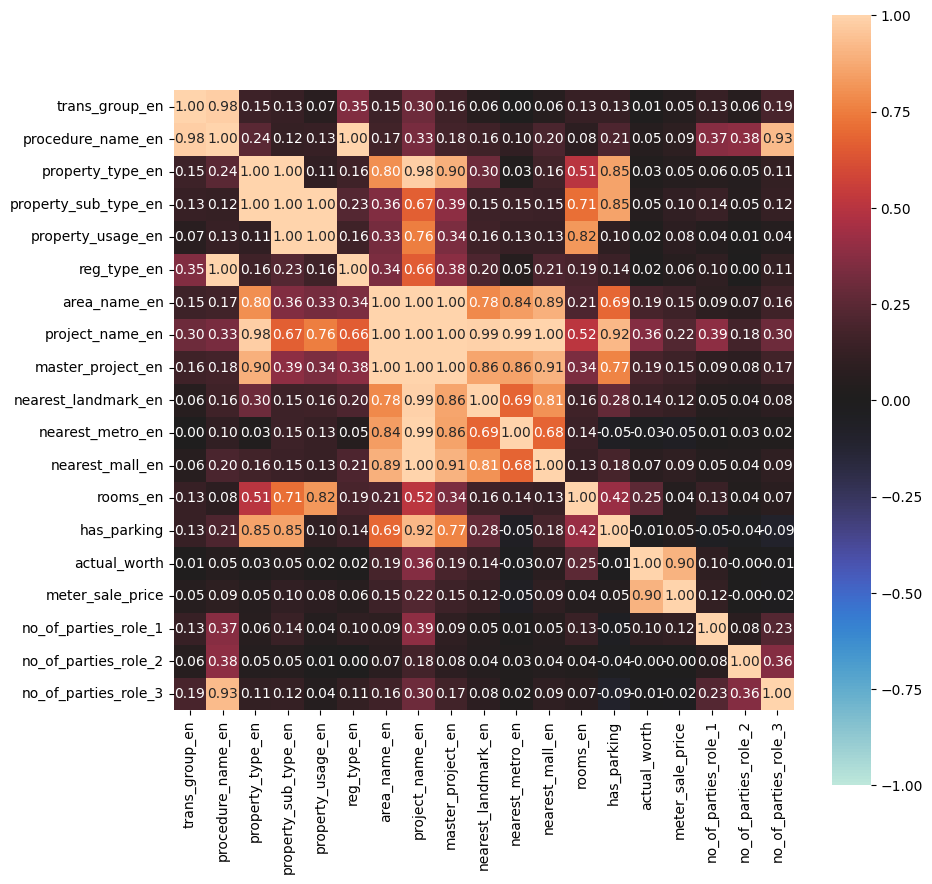

In [18]:
# Calculating the correlation between all the columns
combined_corr = associations(transactions_df, filename="correlation_matrix.png", figsize=(10, 10))

In [82]:
# Color coding the correlation matrix
tdf_combined_corr = combined_corr['corr']
tdf_combined_corr.style.background_gradient()

,trans_group_en,procedure_name_en,property_type_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,project_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,actual_worth,meter_sale_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
trans_group_en,1.000000,0.979397,0.154461,0.130913,0.067828,0.351755,0.150471,0.302431,0.162989,0.061559,0.003695,0.058983,0.127590,0.126526,0.013065,0.051034,0.125313,0.058144,0.192221
procedure_name_en,0.979397,1.000000,0.244190,0.122276,0.128990,0.999969,0.171096,0.333248,0.175466,0.161257,0.102313,0.202696,0.078831,0.209313,0.048271,0.086753,0.370341,0.383958,0.928454
property_type_en,0.154461,0.244190,1.000000,0.999993,0.109051,0.157394,0.803775,0.982574,0.895930,0.302633,0.029723,0.164166,0.507525,0.852377,0.026648,0.051786,0.055838,0.045141,0.113002
property_sub_type_en,0.130913,0.122276,0.999993,1.000000,0.999995,0.229782,0.357150,0.667318,0.388838,0.152872,0.149311,0.148124,0.714375,0.854033,0.053200,0.102678,0.139791,0.051631,0.121657
property_usage_en,0.067828,0.128990,0.109051,0.999995,1.000000,0.157234,0.325540,0.755584,0.336611,0.163121,0.131458,0.127216,0.822846,0.096252,0.019813,0.080182,0.040631,0.011849,0.044903
reg_type_en,0.351755,0.999969,0.157394,0.229782,0.157234,1.000000,0.338122,0.661559,0.376970,0.204562,0.047251,0.209737,0.193544,0.140951,0.015320,0.056626,0.095695,0.003751,0.111178
area_name_en,0.150471,0.171096,0.803775,0.357150,0.325540,0.338122,1.000000,0.998596,0.997555,0.784684,0.838414,0.891846,0.206775,0.689691,0.187357,0.149129,0.090685,0.074898,0.162365
project_name_en,0.302431,0.333248,0.982574,0.667318,0.755584,0.661559,0.998596,1.000000,0.998743,0.989214,0.992950,0.998284,0.515464,0.921498,0.360910,0.219720,0.385804,0.176793,0.298347
master_project_en,0.162989,0.175466,0.895930,0.388838,0.336611,0.376970,0.997555,0.998743,1.000000,0.860811,0.858154,0.905312,0.342355,0.771227,0.193026,0.153495,0.094567,0.079455,0.168173
nearest_landmark_en,0.061559,0.161257,0.302633,0.152872,0.163121,0.204562,0.784684,0.989214,0.860811,1.000000,0.687358,0.810305,0.161264,0.277690,0.144463,0.124184,0.053686,0.039113,0.078881


In [20]:
# Keeping only columns that have correlation greater than 0.7 or less than -0.7
tdf_cols = []
for i in tdf_combined_corr.columns:
    for j in tdf_combined_corr.index:
        if i != j:
            if tdf_combined_corr[i][j] > 0.7 or tdf_combined_corr[i][j] < -0.7:
                tdf_cols.append(i)
                tdf_cols.append(j)

tdf_cols = list(set(tdf_cols))
print('Length of tdf_cols:', len(tdf_cols))
tdf_cols

Length of tdf_cols: 17


['property_sub_type_en',
 'nearest_mall_en',
 'meter_sale_price',
 'procedure_name_en',
 'property_usage_en',
 'master_project_en',
 'nearest_landmark_en',
 'nearest_metro_en',
 'actual_worth',
 'project_name_en',
 'property_type_en',
 'rooms_en',
 'no_of_parties_role_3',
 'area_name_en',
 'trans_group_en',
 'reg_type_en',
 'has_parking']

In [21]:
# Keeping the columns that have correlation greater than 0.7 or less than -0.7
transactions_df = transactions_df[tdf_cols]
transactions_df.head()

,property_sub_type_en,nearest_mall_en,meter_sale_price,procedure_name_en,property_usage_en,master_project_en,nearest_landmark_en,nearest_metro_en,actual_worth,project_name_en,property_type_en,rooms_en,no_of_parties_role_3,area_name_en,trans_group_en,reg_type_en,has_parking
0,Flat,Mall of the Emirates,10506.05,Mortgage Registration,Residential,TECOM Site B,Burj Al Arab,9,1337000.0,J8,Unit,2 B/R,0.0,Al Safouh First,Mortgages,Existing Properties,1
1,Flat,Marina Mall,7847.05,Sell,Residential,Jumeirah Islands,Sports City Swimming Academy,19,550000.0,NEW DUBAI GATE2,Unit,1 B/R,0.0,Al Thanyah Fifth,Sales,Existing Properties,1
2,Flat,Marina Mall,7574.11,Sell - Pre registration,Residential,Jumeirah Islands,Sports City Swimming Academy,19,650616.0,NEW DUBAI GATE2,Unit,1 B/R,0.0,Al Thanyah Fifth,Sales,Off-Plan Properties,1
3,Flat,Marina Mall,9273.79,Sell,Residential,Jumeirah Islands,Sports City Swimming Academy,19,650000.0,NEW DUBAI GATE2,Unit,1 B/R,0.0,Al Thanyah Fifth,Sales,Existing Properties,1
4,Flat,Marina Mall,11335.22,Sell - Pre registration,Residential,Jumeirah Islands,Sports City Swimming Academy,19,463383.0,NEW DUBAI GATE2,Unit,Studio,0.0,Al Thanyah Fifth,Sales,Off-Plan Properties,1


In [22]:
# Function to display value counts and plot a bar graph
def display_value_counts(df, col):
    # Getting value counts
    counts = df[col].value_counts()

    # Creating a DataFrame from the value counts
    counts_df = pd.DataFrame({col: counts.index, 'Count': counts.values})

    # Sorteing the df by value
    counts_df = counts_df.sort_values(by=col, ascending=True)

    # Displaying value counts as a df
    print("Value Counts for Column '{}'".format(col))
    print(counts_df)

    # Displaying value counts as a bar graph
    fig = px.bar(counts_df, x=col, y='Count', labels={col: col}, title='Value Counts for Column "{}"'.format(col))
    fig.show()

# Function to display value counts and plot an area graph
def display_area_chart(df, col):
    # Getting value counts
    counts = df[col].value_counts()

    # Creating a DataFrame from the value counts
    counts_df = pd.DataFrame({col: counts.index, 'Count': counts.values})

    # Sorteing the df by value
    counts_df[col] = counts_df[col].astype(str)  # Ensure sorting works for both numeric and string values
    counts_df = counts_df.sort_values(by=col, ascending=True)

    # Displaying value counts as a df
    print("Value Counts for Column '{}'".format(col))
    print(counts_df)

    # displaying value counts as an area graph
    fig = px.area(counts_df, x=col, y='Count', labels={col: col, 'Count': 'Frequency'}, title='Value Counts for Column "{}"'.format(col))
    fig.show()

In [23]:
# Function to print column names that have infrequent values
def get_infrequent_columns(df, threshold=500):
    infrequent_columns = []
    for col in df.columns:
        counts = df[col].value_counts()
        infrequent_values = counts[counts < threshold]
        if not infrequent_values.empty:
            infrequent_columns.append(col)
    return infrequent_columns

infrequent_columns = get_infrequent_columns(transactions_df, 400)
infrequent_columns

['property_sub_type_en',
 'meter_sale_price',
 'procedure_name_en',
 'property_usage_en',
 'master_project_en',
 'nearest_metro_en',
 'actual_worth',
 'project_name_en',
 'rooms_en',
 'no_of_parties_role_3',
 'area_name_en']

In [24]:
# Since actual_worth and meter_sale_price columns are continuous
# Exclude them from the infrequent_columns list
infrequent_columns.remove('actual_worth')
infrequent_columns.remove('meter_sale_price')

In [25]:
display_value_counts(transactions_df, 'nearest_metro_en')

Value Counts for Column 'nearest_metro_en'
    nearest_metro_en  Count
25                 0   1872
16                 1   4854
20                 2   2723
21                 3   2593
0                  4  65469
3                  5  52787
7                  6  19027
22                 7   2575
4                  8  41001
2                  9  53525
18                10   3805
28                11   1791
30                12    125
6                 13  21552
17                14   4831
26                15   1862
12                16  12037
11                17  12648
14                18   8632
5                 19  36103
24                20   2001
13                21   9065
15                22   7276
8                 23  17425
1                 24  57213
19                25   3235
31                26      5
10                27  14591
29                28    733
9                 29  16309
23                30   2366
27                31   1832


In [26]:
display_value_counts(transactions_df, 'no_of_parties_role_3')

Value Counts for Column 'no_of_parties_role_3'
   no_of_parties_role_3   Count
0                   0.0  462925
3                   1.0      84
1                   2.0   15472
2                   4.0    3358
4                   6.0      18
5                   8.0       6


In [27]:
display_area_chart(transactions_df, 'property_usage_en')

Value Counts for Column 'property_usage_en'
  property_usage_en   Count
1        Commercial   45847
2      Hospitality    28075
0       Residential  407902
3           Storage      39


In [28]:
display_area_chart(transactions_df, 'procedure_name_en')

Value Counts for Column 'procedure_name_en'
                             procedure_name_en   Count
31                         Delayed Development       1
30                 Delayed Lease to Own Modify       1
14           Delayed Lease to Own Registration     548
6                             Delayed Mortgage    4111
3                                 Delayed Sell   26613
21      Delayed Sell Lease to Own Registration     108
23                        Development Mortgage      79
19                    Development Registration     234
13   Development Registration Pre-Registration     859
5                                        Grant   14254
27                           Grant Development       4
11                      Grant Pre-Registration    1012
15                       Grant on Delayed Sell     433
20                  Lease Finance Modification     144
9                   Lease Finance Registration    2870
22                         Lease to Own Modify     101
4                    

In [29]:
display_area_chart(transactions_df, 'master_project_en')

Value Counts for Column 'master_project_en'
                                master_project_en  Count
10                                      Al Furjan  12635
8                                           Arjan  16578
4                                    Burj Khalifa  38125
0                                    Business Bay  68348
48                                  Business Park    512
22                                      City Walk   3365
21                                Culture Village   3488
46                                       DMCC-EZ2    873
11                                    DUBAI HILLS   8594
52                      DUBAI HILLS - CLUB VILLAS    328
51                       DUBAI HILLS - GOLF GROVE    352
34                          DUBAI HILLS - MAPLE 1   1623
36                          DUBAI HILLS - MAPLE 2   1554
39                          DUBAI HILLS - MAPLE 3   1305
13                             DUBAI HILLS - PARK   6461
32                            Down Town Jaba

In [30]:
# Function to drop infrequent values from columns
def drop_infrequent_values(df, col_list, threshold=400):
    for col in col_list:
        counts = df[col].value_counts()
        infrequent_values = counts[counts < threshold].index
        df = df[~df[col].isin(infrequent_values)]
    return df

In [31]:
# Dropping infrequent values from columns
transactions_df = drop_infrequent_values(transactions_df, infrequent_columns, 400)
transactions_df.reset_index(drop=True, inplace=True)
transactions_df.shape

(376164, 17)

### **3. Data Transformation**

In [32]:
def label_encode_string_columns(df):
    # Getting list of string/object columns
    string_cols = df.select_dtypes(include=['object']).columns

    # Creating label encoder for each string column
    # and transforming the column
    encoders = {}
    for col in string_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoders[col] = encoder

    # Saving encoders using joblib to be used while predicting new data
    for col, encoder in encoders.items():
        joblib.dump(encoder, f"{col}_encoder.joblib")

    return df

In [33]:
# Label encoding string columns
encoded_df = label_encode_string_columns(transactions_df)

In [34]:
# Scaling only the actual_worth and meter_sale_price columns
# Since they are continuous and have a wide range of values
scaler = MinMaxScaler()
encoded_df[['actual_worth', 'meter_sale_price']] = scaler.fit_transform(encoded_df[['actual_worth', 'meter_sale_price']])
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [35]:
encoded_df.head()

,property_sub_type_en,nearest_mall_en,meter_sale_price,procedure_name_en,property_usage_en,master_project_en,nearest_landmark_en,nearest_metro_en,actual_worth,project_name_en,property_type_en,rooms_en,no_of_parties_role_3,area_name_en,trans_group_en,reg_type_en,has_parking
0,0,4,0.000360,13,2,23,8,19,0.000183,245,0,0,0.0,13,2,0,1
1,0,4,0.000347,14,2,23,8,19,0.000216,245,0,0,0.0,13,2,1,1
2,0,4,0.000425,13,2,23,8,19,0.000216,245,0,0,0.0,13,2,0,1
3,0,4,0.000520,14,2,23,8,19,0.000154,245,0,9,0.0,13,2,1,1
4,0,4,0.000293,14,2,23,8,19,0.000190,245,0,0,0.0,13,2,1,1


### **4. Training the model**

In [36]:
# Splitting the data into features and target
X = encoded_df.drop('nearest_metro_en', axis=1)
y = encoded_df['nearest_metro_en']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **4.1 Weak learning Classifiers**

In [37]:
# Function to train and save the model to df
def train_and_evaluate_model(df, model, model_name, X_train, y_train, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)

    # Getting predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Getting accuracy and other metrics
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    cohen_kappa = cohen_kappa_score(y_test, test_preds)
    hamming = hamming_loss(y_test, test_preds)
    jaccard = jaccard_score(y_test, test_preds, average='weighted')
    matthews = matthews_corrcoef(y_test, test_preds)

    # Creating a DataFrame to store the results
    results = pd.DataFrame({'Model': [model_name],
                            'Model Object': [model],
                            'Train Accuracy': [train_acc],
                            'Test Accuracy': [test_acc],
                            'Cohen Kappa': [cohen_kappa],
                            'Hamming Loss': [hamming],
                            'Jaccard Score': [jaccard],
                            'Matthews Correlation': [matthews]
                            })
    df = pd.concat([df, results], ignore_index=True)
    return df

In [38]:
# Training a Decision Tree model
scores_df = pd.DataFrame()
scores_df = train_and_evaluate_model(scores_df, DecisionTreeClassifier(random_state=42), 'Decision Tree', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935


In [39]:
# Training a Logistic Regression model
scores_df = train_and_evaluate_model(scores_df, LogisticRegression(random_state=42), 'Logistic Regression', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935
1,Logistic Regression,LogisticRegression(random_state=42),0.532587,0.533410,0.484365,0.466590,0.345790,0.488190


In [40]:
# Training a KNN model
scores_df = train_and_evaluate_model(scores_df, KNeighborsClassifier(), 'KNN', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935
1,Logistic Regression,LogisticRegression(random_state=42),0.532587,0.533410,0.484365,0.466590,0.345790,0.488190
2,KNN,KNeighborsClassifier(),0.996637,0.994710,0.994224,0.005290,0.989600,0.994225


##### **4.2 Bagging Classifier**

In [41]:
# Custom Bagging Classifier
class Bagging:
    # Constructor
    def __init__(self, base_estimator, n_estimators=10, max_samples=1.0, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.estimators = []
        self.oob_samples = []

    # Bootstrapping method: Fits the base estimator to random subsets of the training data
    def bootstrapping(self, X, y):
        # Set random state for reproducibility
        rng = np.random.RandomState(self.random_state)
        n_samples = X.shape[0]
        max_samples = int(self.max_samples * n_samples)

        # Generate random indices for bootstrapping
        indices = rng.randint(0, n_samples, size=(self.n_estimators, max_samples))
        self.oob_samples = [np.setdiff1d(np.arange(n_samples), indices[i]) for i in range(self.n_estimators)]

        # Reset indices of X and y
        X_reset = X.reset_index(drop=True)
        y_reset = y.reset_index(drop=True)

        # Fit the base estimator to the bootstrapped samples
        for i in range(self.n_estimators):
            estimator = clone(self.base_estimator)
            X_subset, y_subset = X_reset.iloc[indices[i]], y_reset.iloc[indices[i]]
            estimator.fit(X_subset, y_subset)
            self.estimators.append(estimator)

    # Aggregation method: Aggregates the predictions of the base estimators
    def aggregation(self, X):
        # Predictions array to store predictions of each estimator
        predictions = np.zeros((X.shape[0], self.n_estimators), dtype=int)

        # Get predictions from each estimator
        for i, estimator in enumerate(self.estimators):
            predictions[:, i] = estimator.predict(X)

        # Perform voting to find the most frequent prediction
        aggregated_predictions, _ = mode(predictions, axis=1)
        return aggregated_predictions.flatten()

    # Out-of-bag score method: Returns the out-of-bag score
    # Out of bag samples are the samples that were not used while training
    # which can be used as a validation set
    def oob_score(self, X, y):
        if not self.oob_samples:
            raise ValueError("Bagging object has not been fit yet.")

        # Predictions array to store predictions of each estimator
        oob_predictions = np.zeros((X.shape[0], self.n_estimators))
        oob_scores = []

        # Loop through each estimator and its out-of-bag samples
        for i, oob_sample_indices in enumerate(self.oob_samples):
            estimator = self.estimators[i]
            oob_predictions_i = estimator.predict(X.iloc[oob_sample_indices])
            oob_predictions[oob_sample_indices, i] = oob_predictions_i
            oob_score_i = estimator.score(X.iloc[oob_sample_indices], y.iloc[oob_sample_indices])
            oob_scores.append(oob_score_i)

        oob_avg_score = np.mean(oob_scores)
        return oob_avg_score

    # Fit method: Fits the bagging classifier to the training data
    def fit(self, X, y):
        self.bootstrapping(X, y)
        return self.estimators

    # Predict method: Predicts the target variable
    def predict(self, X):
        return self.aggregation(X)

    # Score method: Returns the accuracy score
    def score(self, X, y):
        predictions = self.predict(X)
        # Convert predictions to integer type if necessary
        predictions = predictions.astype(int)
        return accuracy_score(y, predictions)

In [42]:
# Creating a Bagging Classifier with a Decision Tree base estimator
bagging_dt = Bagging(base_estimator=DecisionTreeClassifier(), n_estimators=10, max_samples=0.8, random_state=42)
scores_df = train_and_evaluate_model(scores_df, bagging_dt, 'Bagging with Decision Tree', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935
1,Logistic Regression,LogisticRegression(random_state=42),0.532587,0.533410,0.484365,0.466590,0.345790,0.488190
2,KNN,KNeighborsClassifier(),0.996637,0.994710,0.994224,0.005290,0.989600,0.994225
3,Bagging with Decision Tree,<__main__.Bagging object at 0x7a80d96261a0>,0.999063,0.995667,0.995269,0.004333,0.991455,0.995270


In [43]:
# Creating a Bagging Classifier with a Logistic Regression base estimator
bagging_lr = Bagging(base_estimator=LogisticRegression(), n_estimators=10, max_samples=0.8, random_state=42)
scores_df = train_and_evaluate_model(scores_df, bagging_lr, 'Bagging with Logistic Regression', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935
1,Logistic Regression,LogisticRegression(random_state=42),0.532587,0.533410,0.484365,0.466590,0.345790,0.488190
2,KNN,KNeighborsClassifier(),0.996637,0.994710,0.994224,0.005290,0.989600,0.994225
3,Bagging with Decision Tree,<__main__.Bagging object at 0x7a80d96261a0>,0.999063,0.995667,0.995269,0.004333,0.991455,0.995270
4,Bagging with Logistic Regression,<__main__.Bagging object at 0x7a80d96275e0>,0.532773,0.533330,0.484489,0.466670,0.350850,0.487056


In [44]:
# Creating a Bagging Classifier with a KNN base estimator
bagging_knn = Bagging(base_estimator=KNeighborsClassifier(), n_estimators=10, max_samples=0.8, random_state=42)
scores_df = train_and_evaluate_model(scores_df, bagging_knn, 'Bagging with KNN', X_train, y_train, X_test, y_test)
scores_df

,Model,Model Object,Train Accuracy,Test Accuracy,Cohen Kappa,Hamming Loss,Jaccard Score,Matthews Correlation
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.999644,0.995361,0.994935,0.004639,0.990882,0.994935
1,Logistic Regression,LogisticRegression(random_state=42),0.532587,0.533410,0.484365,0.466590,0.345790,0.488190
2,KNN,KNeighborsClassifier(),0.996637,0.994710,0.994224,0.005290,0.989600,0.994225
3,Bagging with Decision Tree,<__main__.Bagging object at 0x7a80d96261a0>,0.999063,0.995667,0.995269,0.004333,0.991455,0.995270
4,Bagging with Logistic Regression,<__main__.Bagging object at 0x7a80d96275e0>,0.532773,0.533330,0.484489,0.466670,0.350850,0.487056
5,Bagging with KNN,<__main__.Bagging object at 0x7a80d96260e0>,0.996378,0.994577,0.994079,0.005423,0.989326,0.994080


##### **4.3 Cross Validation**

In [45]:
# Custom cross-validation class
import random
class cross_validation:
    # Constructor
    def __init__(self, estimator, X, y, shuffle = False, n_splits=5, random_state=None):
        self.estimator = estimator
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.n_splits = n_splits
        self.random_state = random_state

    def __shuffle_sets(self):
         # Set random state for reproducibility
        np.random.seed(self.random_state)
        indices = np.arange(len(self.X))
        np.random.shuffle(indices)
        self.X = [self.X.iloc[i] for i in indices]
        self.y = [self.y.iloc[i] for i in indices]
        return self.X, self.y



    # Method to split the data into training and testing sets
    def __split_data(self):
       if self.shuffle == True & self.random_state != None:
           self.X, self.y = self.__shuffle_sets()
        # Split the data into n_splits

       fold_size = len(self.X) // self.n_splits
       X_folds = [self.X[i:i+fold_size] for i in range(0, len(self.X), fold_size)]
       y_folds = [self.y[i:i+fold_size] for i in range(0, len(self.y), fold_size)]
    # Yield the training and testing sets to be used for cross-validation
       return X_folds, y_folds

    def __validate(self):
        accuracy_scores = []
        X_folds, y_folds = self.__split_data()
        for i in range(self.n_splits):
            X_test = X_folds[i]
            y_test = y_folds[i]
            X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
            y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])

            # Train and evaluate the classifier
            self.estimator.fit(X_train, y_train)
            y_pred = self.estimator.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def generate_result(self):
        accuracy_scores = self.__validate()
        print("Scores: \n")
        print(accuracy_scores)
        print("\n" * 5)
        print("Mean score:")
        print(np.mean(accuracy_scores))


In [46]:
#Cross validation for decision tree
cross_val_dt = cross_validation(DecisionTreeClassifier(random_state=42), X, y, True, 10, random_state = 42)

In [47]:
cross_val_dt.generate_result()

Scores: 

[0.9950287111867291, 0.9959591663122076, 0.9953477243726074, 0.9961984262016164, 0.9955603998298597, 0.9952148022118248, 0.9955603998298597, 0.9954008932369205, 0.995374308804764, 0.9957730752871119]






Mean score:
0.9955417907273499


In [48]:
#Cross validation for logistic regression
cross_val_lr = cross_validation(LogisticRegression(random_state=42), X, y, True, 10, random_state = 42)

In [49]:
cross_val_lr.generate_result()

Scores: 

[0.5355168013611229, 0.4964908549553382, 0.5290036154827733, 0.5237398979157806, 0.5220384942577626, 0.5119098256061251, 0.5096235644406636, 0.5141429179072735, 0.528232666950234, 0.5280465759251383]






Mean score:
0.5198745214802212


In [50]:
#Cross validation for knn
cross_val_knn = cross_validation(KNeighborsClassifier(), X, y, True, 10, random_state = 42)

In [51]:
cross_val_knn.generate_result()

Scores: 

[0.9947628668651638, 0.9957464908549554, 0.9952679710761378, 0.9954008932369205, 0.9950552956188856, 0.995374308804764, 0.9951084644831987, 0.9950287111867291, 0.9950818800510421, 0.9948692045937899]






Mean score:
0.9951696086771588


### **5. Plotting the property locations**

In [68]:
#To make a map that resembles dubai, we first get a csv of the metro stations and their locations.

# Reading the data from the csv file
metro_stations_df = pd.read_csv('metro_stations.csv')

# Get the value counts for metro stations
metro_counts_df = transactions_df['nearest_metro_en'].value_counts().to_frame().reset_index()
metro_counts_df.columns = ['Metro Station', 'Metro Count']

# Get the value counts for area names
area_counts_df = transactions_df['area_name_en'].value_counts().to_frame().reset_index()
area_counts_df.columns = ['Area Name', 'Area Count']

metro_counts_df['Metro Station'] = metro_counts_df['Metro Station'].astype(str)

# Concatenate the two DataFrames along the columns axis
combined_counts_df = pd.concat([metro_counts_df, area_counts_df], axis=1)

# Replace specific values in the combined DataFrame
replace_dict = {
    '4': 'Burj Khalifa/ Dubai Mall Metro Station',
    '5': 'Business Bay Metro Station',
    '24': 'Nakheel Metro Station',
    '8': 'DAMAC Properties Metro Station',
    '19': 'Jumeirah Lakes Towers Metro Station',
    '9': 'Dubai Internet City Metro Station',
    '23': 'Mina Seyahi',
    '13': 'First Abu Dhabi Bank Metro Station',
    '6': 'Creek Metro Station',
    '26': 'Palm Jumeirah',
    '17': 'Jumeirah Beach Resdency',
    '21': 'Marina Mall Metro Station',
    '18': 'Jumeirah Beach Residency',
    '22': 'Marina Towers',
    '28': 'Sharaf DG Metro Station',
    '16': 'Ibn Battuta Metro Station',
    '10': 'Dubai Marina',
    '14': 'Nakheel Harbour & Tower Metro Station',
    '2': 'Al Jafiliya Metro Station',
    '1': 'Al Jadaf Metro Station',
    '25': 'Noor Bank Metro Station',
    '15': 'Dubai Healthcare City Metro Station',
    '20': 'Knowledge Village',
    '3': 'Al Sufouh',
    '29': 'UAE Exchange Metro Station',
    '11': 'Energy Metro Station',
    '27': 'Rashidiya Metro Station',
    '0': 'Al Ghubaiba Metro Station',
    'nan': 'DANUBE Metro Station'  # Handle NaN values
}

# Apply replacements to 'Metro Station' column
combined_counts_df.replace({"Metro Station": replace_dict, "Area Name": replace_dict}, inplace=True)

# Display the resulting DataFrame
display(combined_counts_df)

,Metro Station,Metro Count,Area Name,Area Count
0,Burj Khalifa/ Dubai Mall Metro Station,58642.0,19,54369
1,Business Bay Metro Station,45103.0,25,47795
2,Nakheel Metro Station,40431.0,13,47368
3,DAMAC Properties Metro Station,36704.0,18,39732
4,Jumeirah Lakes Towers Metro Station,33333.0,1,33016
5,Dubai Internet City Metro Station,30335.0,5,20044
6,First Abu Dhabi Bank Metro Station,17919.0,28,18822
7,Mina Seyahi,16797.0,20,17590
8,Creek Metro Station,15023.0,12,17569
9,Rashidiya Metro Station,12425.0,26,15514


In [77]:
# Merge DataFrames on 'nearest_metro_en' and 'station_name'
metro_coordinates_df = pd.merge(
    combined_counts_df,
    metro_stations_df[['station_name', 'station_location_longitiude', 'station_location_latitiude']],
    left_on='Metro Station',  # Update the column name
    right_on='station_name',
    how='left'
)

# Display the resulting DataFrame
display(metro_coordinates_df[['Metro Station', 'station_name', 'station_location_longitiude', 'station_location_latitiude']])

,Metro Station,station_name,station_location_longitiude,station_location_latitiude
0,Burj Khalifa/ Dubai Mall Metro Station,Burj Khalifa/ Dubai Mall Metro Station,55.269518,25.201401
1,Business Bay Metro Station,Business Bay Metro Station,55.260419,25.191275
2,Nakheel Metro Station,Nakheel Metro Station,55.158026,25.088917
3,DAMAC Properties Metro Station,DAMAC Properties Metro Station,55.147523,25.079929
4,Jumeirah Lakes Towers Metro Station,Jumeirah Lakes Towers Metro Station,55.138673,25.070824
5,Dubai Internet City Metro Station,NaN,NaN,NaN
6,First Abu Dhabi Bank Metro Station,NaN,NaN,NaN
7,Mina Seyahi,NaN,NaN,NaN
8,Creek Metro Station,Creek Metro Station,55.338953,25.218949
9,Rashidiya Metro Station,Rashidiya Metro Station,55.391198,25.230223


Adding the remaining metro stations corrdinates manually

In [78]:
# Dubai Internet City Metro Station
metro_coordinates_df.iloc[5, metro_coordinates_df.columns.get_loc('station_name')] = 'Dubai Internet City Metro Station'
metro_coordinates_df.iloc[5, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.102200372871604
metro_coordinates_df.iloc[5, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.17363899596171

# Al Khail Metro Station (Mina Seyahi)
metro_coordinates_df.iloc[6, metro_coordinates_df.columns.get_loc('Metro Station')] = 'Al Khail Metro Station'
metro_coordinates_df.iloc[6, metro_coordinates_df.columns.get_loc('station_name')] = 'Al Khail Metro Station'
metro_coordinates_df.iloc[6, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.089516787624202
metro_coordinates_df.iloc[6, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.158169070406636

# Equiti Metro Station
metro_coordinates_df.iloc[7, metro_coordinates_df.columns.get_loc('Metro Station')] = 'Equiti Metro Station'
metro_coordinates_df.iloc[7, metro_coordinates_df.columns.get_loc('station_name')] = 'Equiti Metro Station'
metro_coordinates_df.iloc[7, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.126374622762253
metro_coordinates_df.iloc[7, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.20762159850706

#The closest thing to Palm Jumeirah (row 9) already exists in the df(DIC)
metro_coordinates_df.loc[5, 'Metro Count'] += metro_coordinates_df.loc[9, 'Metro Count']
metro_coordinates_df.drop(index=9, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

# DMCC Metro Station
metro_coordinates_df.iloc[9, metro_coordinates_df.columns.get_loc('Metro Station')] = 'DMCC Metro Station'
metro_coordinates_df.iloc[9, metro_coordinates_df.columns.get_loc('station_name')] = 'DMCC Metro Station'
metro_coordinates_df.iloc[9, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.07142753512518
metro_coordinates_df.iloc[9, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.13913938382597

#closest is DMCC which is already available
metro_coordinates_df.loc[9, 'Metro Count'] += metro_coordinates_df.loc[10, 'Metro Count']
metro_coordinates_df.drop(index=10, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

#duplicate row dropped and count transferred.
metro_coordinates_df.loc[9, 'Metro Count'] += metro_coordinates_df.loc[10, 'Metro Count']
metro_coordinates_df.drop(index=10, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

# Sobha Realty Metro Station
metro_coordinates_df.iloc[10, metro_coordinates_df.columns.get_loc('Metro Station')] = 'Sobha Realty Metro Station'
metro_coordinates_df.iloc[10, metro_coordinates_df.columns.get_loc('station_name')] = 'Sobha Realty Metro Station'
metro_coordinates_df.iloc[10, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.080158002953368
metro_coordinates_df.iloc[10, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.14763280481733

#closest is DMCC which is already available
metro_coordinates_df.loc[9, 'Metro Count'] += metro_coordinates_df.loc[13, 'Metro Count']
metro_coordinates_df.drop(index=13, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

#closest is Al Khail which is already available.
metro_coordinates_df.loc[6, 'Metro Count'] += metro_coordinates_df.loc[18, 'Metro Count']
metro_coordinates_df.drop(index=18, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

#closest is DIC which is already available.
metro_coordinates_df.loc[5, 'Metro Count'] += metro_coordinates_df.loc[18, 'Metro Count']
metro_coordinates_df.drop(index=18, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

# Energy Metro Station
metro_coordinates_df.iloc[19, metro_coordinates_df.columns.get_loc('station_name')] = 'Energy Metro Station'
metro_coordinates_df.iloc[19, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.026595415839324
metro_coordinates_df.iloc[19, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.10119231553445

# DANUBE Metro Station
metro_coordinates_df.iloc[22, metro_coordinates_df.columns.get_loc('station_name')] = 'DANUBE Metro Station'
metro_coordinates_df.iloc[22, metro_coordinates_df.columns.get_loc('station_location_latitiude')] = 25.001432254323753
metro_coordinates_df.iloc[22, metro_coordinates_df.columns.get_loc('station_location_longitiude')] = 55.09574448671305

#no count
metro_coordinates_df.drop(index=22, inplace=True)
metro_coordinates_df.reset_index(drop=True, inplace=True)

metro_coordinates_df = metro_coordinates_df.dropna()

metro_coordinates_df

,Metro Station,Metro Count,Area Name,Area Count,station_name,station_location_longitiude,station_location_latitiude
0,Burj Khalifa/ Dubai Mall Metro Station,58642.0,19,54369,Burj Khalifa/ Dubai Mall Metro Station,55.269518,25.201401
1,Business Bay Metro Station,45103.0,25,47795,Business Bay Metro Station,55.260419,25.191275
2,Nakheel Metro Station,40431.0,13,47368,Nakheel Metro Station,55.158026,25.088917
3,DAMAC Properties Metro Station,36704.0,18,39732,DAMAC Properties Metro Station,55.147523,25.079929
4,Jumeirah Lakes Towers Metro Station,33333.0,1,33016,Jumeirah Lakes Towers Metro Station,55.138673,25.070824
5,Dubai Internet City Metro Station,44352.0,5,20044,Dubai Internet City Metro Station,55.173639,25.102200
6,Al Khail Metro Station,19633.0,28,18822,Al Khail Metro Station,55.158169,25.089517
7,Equiti Metro Station,16797.0,20,17590,Equiti Metro Station,55.207622,25.126375
8,Creek Metro Station,15023.0,12,17569,Creek Metro Station,55.338953,25.218949
9,DMCC Metro Station,30917.0,7,14603,DMCC Metro Station,55.139139,25.071428


**All metro stations on the map**

In [79]:
import folium
from IPython.display import display

# Create a map centered around Dubai
map_dubai = folium.Map(location=[25.191275, 55.260419], zoom_start=11)

#Metro station color
metro_color = 'red'

# Add markers for each metro station in metro_coordinates_df
for index, row in metro_coordinates_df.iterrows():
    folium.Marker(
        location=[row['station_location_latitiude'], row['station_location_longitiude']],
        popup=row['Metro Station'],
        icon=folium.Icon(color=metro_color, icon='train', prefix='fa')# Using a train icon for metro stations
    ).add_to(map_dubai)

#Display map
display(map_dubai)

**All the property locations on the map**

Note: Each blue dot represents 400 properties since we set a threshold of 400 for each station.

In [80]:
import folium
import numpy as np
from IPython.display import display

# Create a map centered around Dubai
map_dubai = folium.Map(location=[25.191275, 55.260419], zoom_start=11)

#Metro station color
metro_color = 'red'

# Add markers for each metro station in metro_coordinates_df
for index, row in metro_coordinates_df.iterrows():
    #Add metro station marker
    folium.Marker(
        location=[row['station_location_latitiude'], row['station_location_longitiude']],
        popup=row['Metro Station'],
        icon=folium.Icon(color=metro_color, icon='train', prefix='fa')# Using a train icon for metro stations
    ).add_to(map_dubai)

    # Calculate the number of points to add based on metro count
    num_points = int(row['Metro Count'] / 400)

    # Add random points around the metro station
    for z in range(num_points):
        # Generate random offset for latitude and longitude
        lat_offset = np.random.uniform(-0.02, 0.01)
        lon_offset = np.random.uniform(-0.02, 0.01)

        #point marker
        folium.CircleMarker(
            location=[row['station_location_latitiude'] + lat_offset, row['station_location_longitiude'] + lon_offset],
            radius=2,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        ).add_to(map_dubai)

# Display map
display(map_dubai)

**More dynamic map**

Note: Each red point represents 2000 properties, while each blue point represents 400 properties.

In [81]:
import folium
import numpy as np
from IPython.display import display

# Create a map centered around Dubai
map_dubai = folium.Map(location=[25.191275, 55.260419], zoom_start=11)

# Function to add points for properties
def add_property_points(location, num_properties, color, map_obj):
    # Calculate the number of red points based on the number of properties
    num_red = int(num_properties // 2000)

    # Adjust the number of blue points to ensure the total matches the property count
    num_blue = int((num_properties - num_red * 2000) // 400)

    #Add red points
    for _ in range(num_red):
        lat_offset = np.random.uniform(-0.02, 0.01)
        lon_offset = np.random.uniform(-0.02, 0.01)
        folium.CircleMarker(
            location=[location[0] + lat_offset, location[1] + lon_offset],
            radius=2,
            color='#CE2029',
            fill=True,
            fill_color='#CE2029',
            fill_opacity=0.6,
        ).add_to(map_obj)

    # Add blue points for remaining properties
    for _ in range(num_blue):
        lat_offset = np.random.uniform(-0.02, 0.01)
        lon_offset = np.random.uniform(-0.02, 0.01)
        folium.CircleMarker(
            location=[location[0] + lat_offset, location[1] + lon_offset],
            radius=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
        ).add_to(map_obj)

# Add markers for each metro station in metro_coordinates_df
for index, row in metro_coordinates_df.iterrows():
    # Add metro station marker
    folium.Marker(
        location=[row['station_location_latitiude'], row['station_location_longitiude']],
        popup=row['Metro Station'],
        icon=folium.Icon(color=metro_color, icon='train', prefix='fa') #Using a train icon for metro stations
    ).add_to(map_dubai)

    # Add property points around the metro station
    add_property_points(
        location=[row['station_location_latitiude'], row['station_location_longitiude']],
        num_properties=row['Metro Count'],
        color='blue',
        map_obj=map_dubai
    )

# Display map
display(map_dubai)

### **6. Evaluation of all models**

In [54]:
# Creating traces for train and test accuracy
train_trace = go.Scatter(x=scores_df['Model'], y=scores_df['Train Accuracy'], name='Train Accuracy', marker=dict(color='pink'))
test_trace = go.Scatter(x=scores_df['Model'], y=scores_df['Test Accuracy'], name='Test Accuracy', marker=dict(color='cyan'))

# Creating layout
layout = go.Layout(title='Train and Test Accuracy for Different Models',
                   xaxis=dict(title='Model'),
                   yaxis=dict(title='Accuracy'))

# Creating figure
fig = go.Figure(data=[train_trace, test_trace], layout=layout)

# Displaying figure
fig.show()

In [57]:
# Create a bar graph for each metric for each model for only the test data
# Make the bars for each metric for each model be grouped together
# This will allow for easy comparison between the models for each metric

# Creating traces for each metric for each model
cohen_kappa_trace = go.Bar(x=scores_df['Model'], y=scores_df['Cohen Kappa'], name='Cohen Kappa', marker=dict(color='pink'))
jaccard_score_trace = go.Bar(x=scores_df['Model'], y=scores_df['Jaccard Score'], name='Jaccard Score', marker=dict(color='cyan'))
matthews_corrcoef_trace = go.Bar(x=scores_df['Model'], y=scores_df['Matthews Correlation'], name='Matthews Correlation', marker=dict(color='violet'))

# Creating layout
layout = go.Layout(title='Comparison of Different Metrics for Each Model',
                   xaxis=dict(title='Model'),
                   yaxis=dict(title='Metric Value'),
                   barmode='group')

# Creating figure
fig = go.Figure(data=[cohen_kappa_trace, jaccard_score_trace, matthews_corrcoef_trace], layout=layout)

# Displaying figure
fig.show()

In [60]:
# Classification report for the best model
predictions = bagging_dt.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00       448
           2       1.00      1.00      1.00       472
           3       1.00      1.00      1.00       397
           4       1.00      1.00      1.00     11581
           5       1.00      1.00      1.00      9030
           6       1.00      1.00      1.00      3012
           8       0.98      0.99      0.99      7416
           9       0.99      1.00      0.99      6026
          10       1.00      1.00      1.00       643
          11       1.00      1.00      1.00       231
          13       1.00      1.00      1.00      3611
          14       1.00      1.00      1.00       774
          15       1.00      1.00      1.00       348
          16       1.00      1.00      1.00       976
          17       1.00      1.00      1.00      2144
          18       1.00      1.00      1.00      1379
          19       1.00    